In [1]:
import sys
sys.path.append("..")

from datetime import datetime
import numpy as np
import ujson as json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from lib.dataclasses import SignalDCT, SignalTime, SingleSample, Sample, SignalSpectrum
from lib.utils import get_sample_from_json
from copy import deepcopy

In [2]:
plt.style.use('ggplot')
from matplotlib.gridspec import GridSpec

Variables

In [3]:
PATH_TO_DATASET_1 = "/workspaces/project/raw/sequence_1/"
PATH_TO_DATASET_2 = "/workspaces/project/raw/sequence_2/"

# Importing data

In [4]:
# valid samples: above id 135 (2022_11_18_10_19)

valid_date = datetime(2022, 11, 18, 10, 19)

sample_list = []
for file_path in tqdm(os.listdir(PATH_TO_DATASET_1)):
    sample_id = file_path.split(".json")[0]
    date = datetime.strptime(sample_id, "%Y_%m_%d_%H_%M")
    if date >= valid_date:
        sample = get_sample_from_json(
            path = PATH_TO_DATASET_1 + file_path,
            sample_id=sample_id
        )
        sample_list.append(sample)

100%|██████████| 2865/2865 [01:03<00:00, 45.17it/s] 


In [5]:
def get_rms(x: list):
    return np.sqrt((x**2).mean())

time_sample = deepcopy(sample_list[10])
time_sample.convert_to_time()

In [6]:
from scipy.fftpack import dct, idct

In [7]:
def get_band_data(x:list, window:int, fun:str="mean") -> list:
    N = len(x)
    assert N % window == 0

    functions = {
        "mean": lambda x: x.mean(axis=1),
        "max": lambda x: x.max(axis=1),
        "min": lambda x: x.min(axis=1),
        "abs-mean": lambda x: np.abs(x).mean(axis=1),
        "abs-median": lambda x: np.median(np.abs(x), axis=1)
    }

    x = np.array(x)
    x = x.reshape(-1, window)
    x = functions[fun](x)
    return list(x)


In [8]:
tensions = [sample.sample_c1.tension for sample in sample_list]
dates = [sample.sampled_at for sample in sample_list]

dct_per_cable = []
for cable in [0,1,2,3]:
    dct_per_cable.append({d: np.array([get_band_data(sample[cable][d].get()[1], window=64, fun="abs-mean") for sample in sample_list]) for d in ["x","y","z"]})

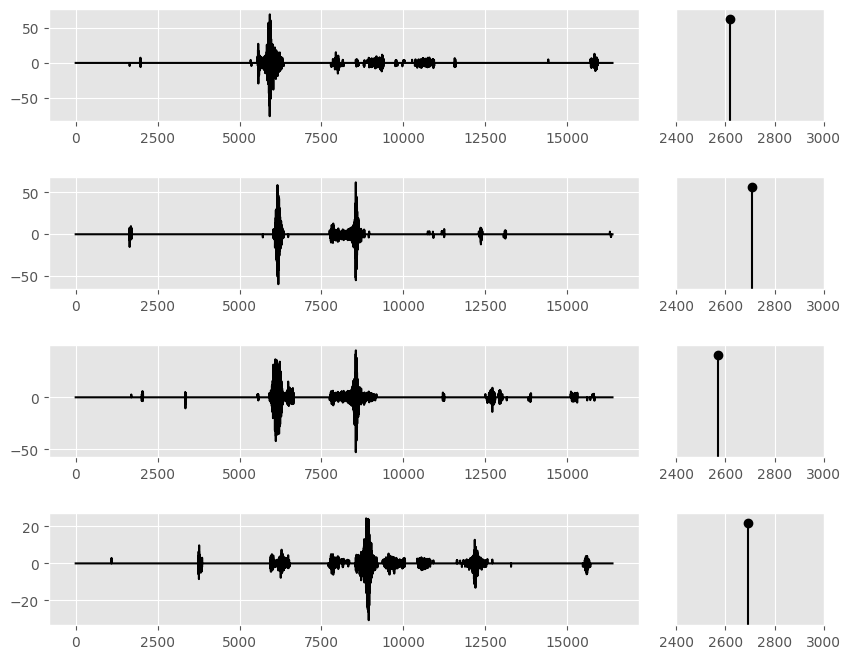

In [9]:
def plot_bar(x, x_min, x_max, ax):
    ax.plot([x,x], [-1,1], marker='o', color='k')
    ax.set_xlim([x_min, x_max])
    ax.set_yticks([])
    ax.set_ylim([0,1.1])    

spec = GridSpec(
    ncols=2, nrows=4,
    width_ratios=[4, 1], wspace=0.1, 
    hspace=0.5, height_ratios=[1, 1, 1, 1]
)

sample = sample_list[100]

t_min = 2400
t_max = 3000

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(spec[0])
x = sample[0]["y"].get()[1]
t = sample[0].tension
ax.plot(x, color='k')
ax = fig.add_subplot(spec[1])
plot_bar(t, t_min, t_max, ax)

ax = fig.add_subplot(spec[2])
x = sample[1]["y"].get()[1]
t = sample[1].tension
ax.plot(x, color='k')
ax = fig.add_subplot(spec[3])
plot_bar(t, t_min, t_max, ax)

ax = fig.add_subplot(spec[4])
x = sample[2]["y"].get()[1]
t = sample[2].tension
ax.plot(x, color='k')
ax = fig.add_subplot(spec[5])
plot_bar(t, t_min, t_max, ax)

ax = fig.add_subplot(spec[6])
x = sample[3]["y"].get()[1]
t = sample[3].tension
ax.plot(x, color='k')
ax = fig.add_subplot(spec[7])
plot_bar(t, t_min, t_max, ax)

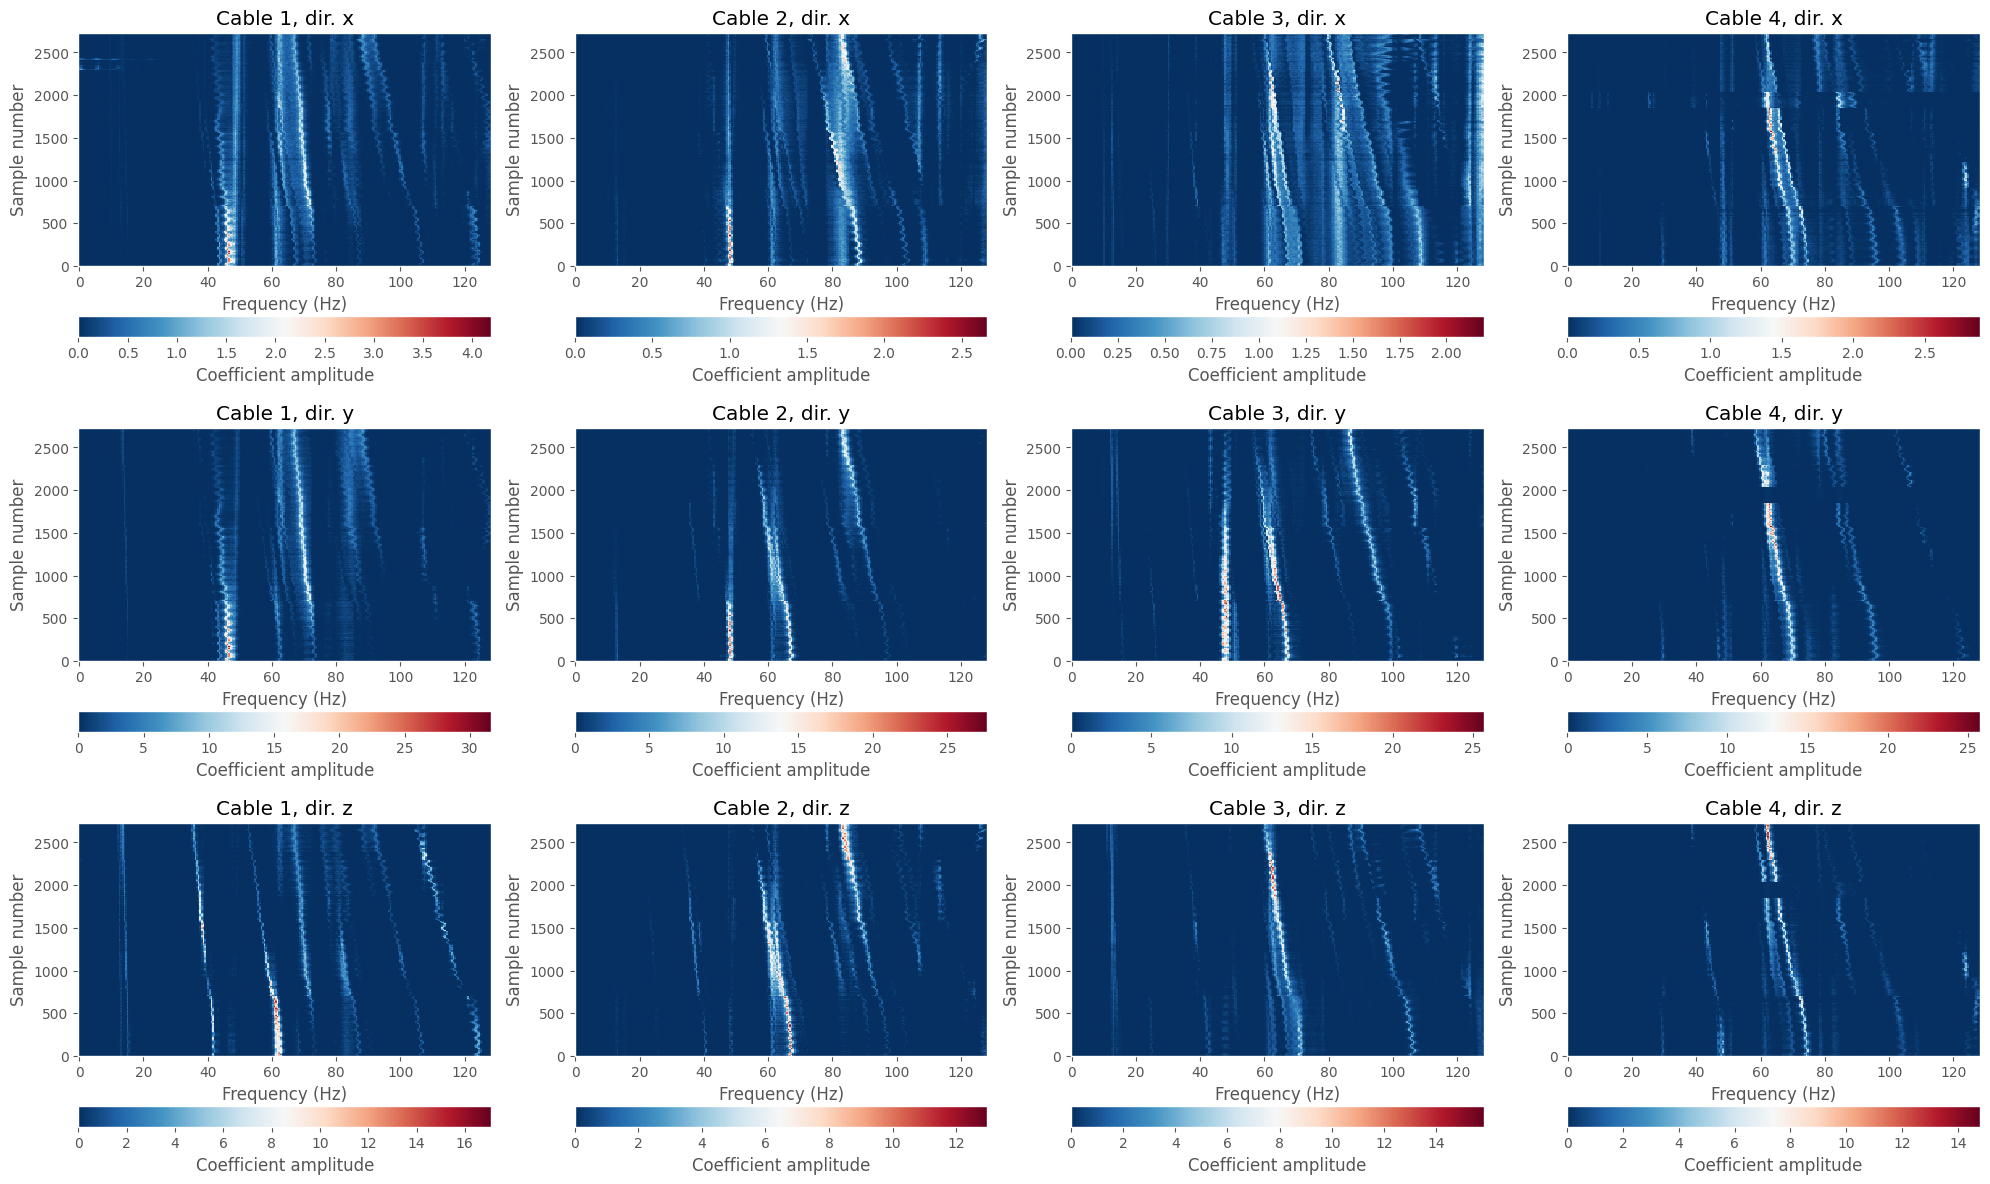

In [25]:
min_x = 0
max_x = len(tensions)

f = np.linspace(0, 128, dct_per_cable[0]["x"].shape[1])
t = np.linspace(0, dct_per_cable[0]["x"].shape[0], dct_per_cable[0]["x"].shape[0])

fig = plt.figure(figsize=(20,12))
cont = 1
for d in ["x","y","z"]:
    for cable in [0,1,2,3]:
        ax = fig.add_subplot(3, 4, cont)
        ax.set_title(f"Cable {cable+1}, dir. {d}")
        pc = ax.pcolormesh(f, t, np.abs(dct_per_cable[cable][d]), cmap="RdBu_r")
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Sample number")
        fig.colorbar(pc, location="bottom", label="Coefficient amplitude")
        cont += 1

fig.tight_layout()

In [23]:
en_per_cable = {}

for cable in [0,1,2,3]:
    en_per_cable[cable] = {d: [sample[cable][d].get_energy() for sample in sample_list] for d in ["x","y","z"]}

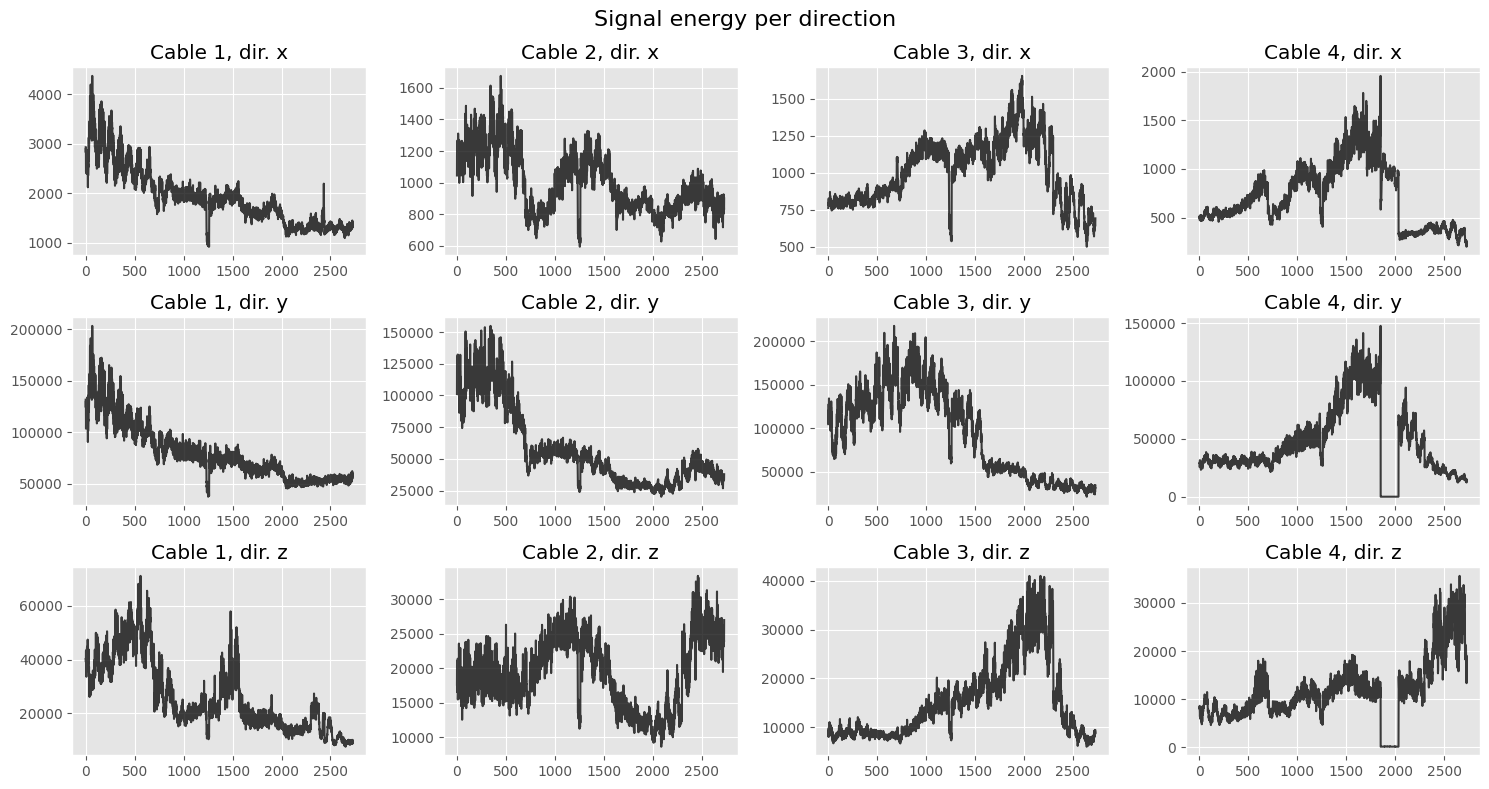

In [16]:
fig = plt.figure(figsize=(15,8))
cont = 1
for d in ["x","y","z"]:
    fig.suptitle("Signal energy per direction", fontsize=16)
    for cable in [0,1,2,3]:
        ax = fig.add_subplot(3, 4, cont)
        ax.set_title(f"Cable {cable+1}, dir. {d}")
        ax.plot(en_per_cable[cable][d], color="k", alpha=0.75)
        cont += 1
    fig.tight_layout()

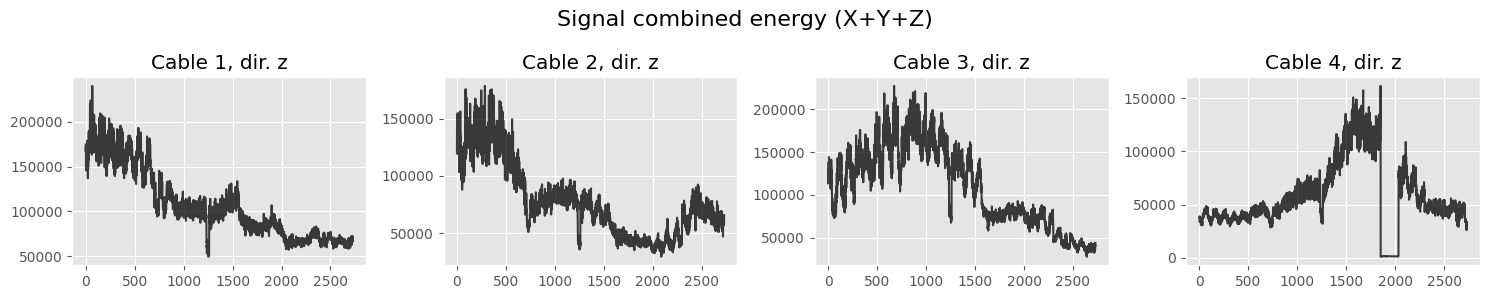

In [21]:
fig = plt.figure(figsize=(15,3))
cont = 1
fig.suptitle("Signal combined energy (X+Y+Z)", fontsize=16)
for cable in [0,1,2,3]:
    ax = fig.add_subplot(1, 4, cont)
    ax.set_title(f"Cable {cable+1}, dir. {d}")
    combined_energy = np.array([en_per_cable[cable][d] for d in ["x","y","z"]]).sum(axis=0)
    ax.plot(combined_energy, color="k", alpha=0.75)
    cont += 1
fig.tight_layout()

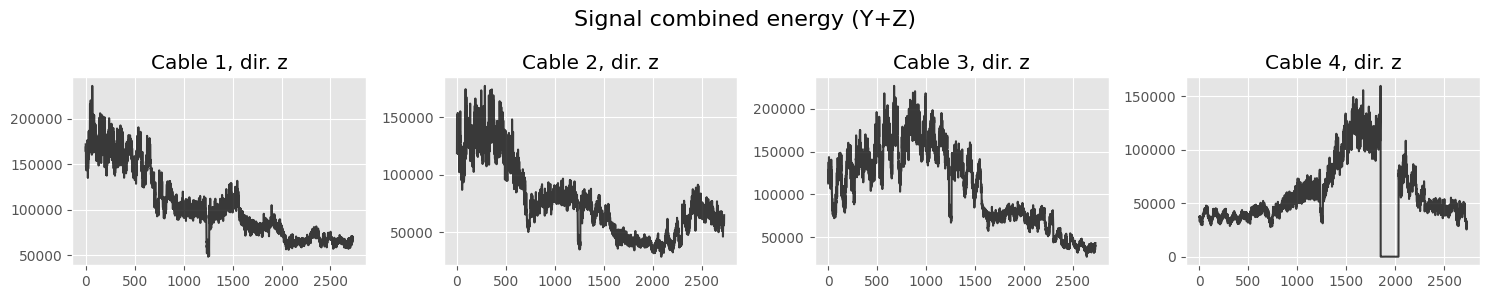

In [22]:
fig = plt.figure(figsize=(15,3))
cont = 1
fig.suptitle("Signal combined energy (Y+Z)", fontsize=16)
for cable in [0,1,2,3]:
    ax = fig.add_subplot(1, 4, cont)
    ax.set_title(f"Cable {cable+1}, dir. {d}")
    combined_energy = np.array([en_per_cable[cable][d] for d in ["y","z"]]).sum(axis=0)
    ax.plot(combined_energy, color="k", alpha=0.75)
    cont += 1
fig.tight_layout()

Identifying interesting bands

In [70]:
coef_per_cable = []

for sample in sample_list:
    coef_per_dir = [sample[0][d].get()[1] for d in ["x", "y", "z"]]
    coef_per_cable.append(np.array(np.abs(coef_per_dir)).sum(axis=0))
mean_coef_per_cable = np.array(coef_per_cable).mean(axis=0)
del(coef_per_cable)

In [77]:
def get_mean_coef_per_cable(sample_list: list, cable: int) -> np.ndarray:
    coef_per_cable = []

    for sample in sample_list:
        coef_per_dir = [sample[cable][d].get()[1] for d in ["x", "y", "z"]]
        coef_per_cable.append(np.array(np.abs(coef_per_dir)).sum(axis=0))
    mean_coef_per_cable = np.array(coef_per_cable).mean(axis=0)
    del(coef_per_cable)
    return mean_coef_per_cable

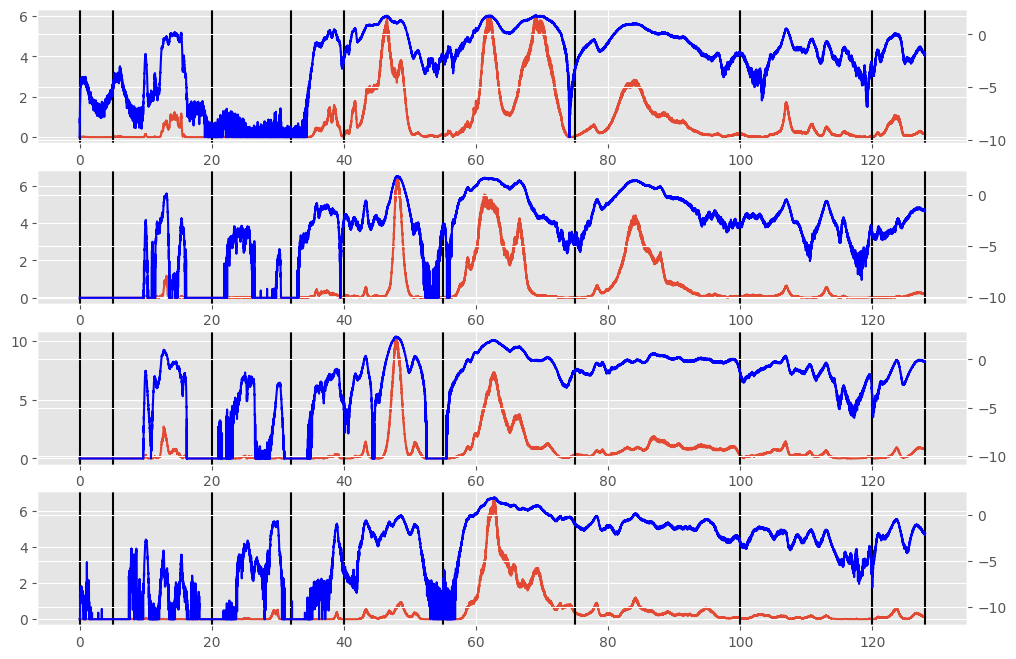

In [100]:
f = np.linspace(0, 128, len(mean_coef_per_cable))

band_limits = [
    0,
    5,
    20,
    32,
    40,
    55,
    75,
    100,
    120,
    128
]

fig = plt.figure(figsize=(12,8))
cont = 1
for cable in [0,1,2,3]:
    ax = fig.add_subplot(4, 1, cont)
    mean_coef_per_cable = get_mean_coef_per_cable(sample_list, cable)
    lowest = mean_coef_per_cable[mean_coef_per_cable>0].min()
    ax.plot(f, mean_coef_per_cable)
    for freq in band_limits:
        ax.axvline(freq, color="k")
    ax2 = ax.twinx()
    ax2.plot(f, np.log(mean_coef_per_cable + lowest), color="blue")
    cont += 1

Energy per frequency band

In [ ]:
band_per_cable = {}
norm_band_per_cable = {}

bands = {
    ""
}

for cable in [0,1,2,3]:
    band_per_cable[cable] = {d: [sample[cable][d].get_energy([50,80]) for sample in sample_list] for d in ["x","y","z"]}
    norm_band_per_cable[cable] = {d: [sample[cable][d].get_energy([50,80], norm=True) for sample in sample_list] for d in ["x","y","z"]}

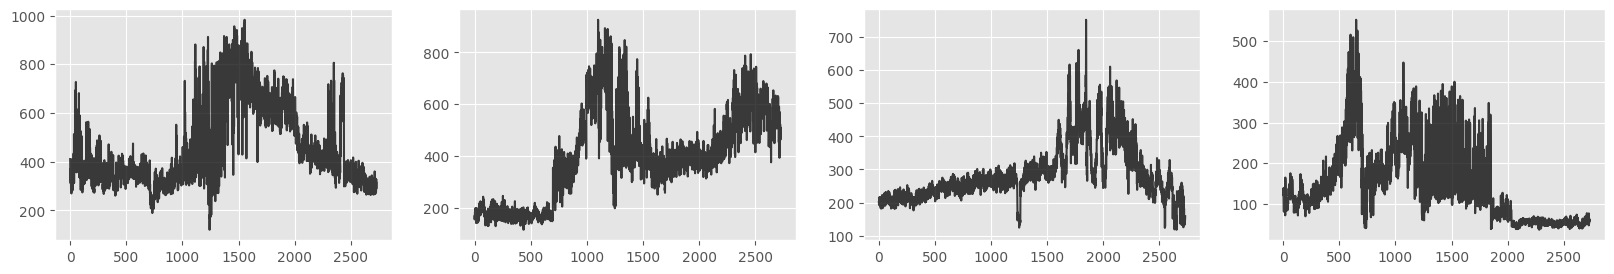

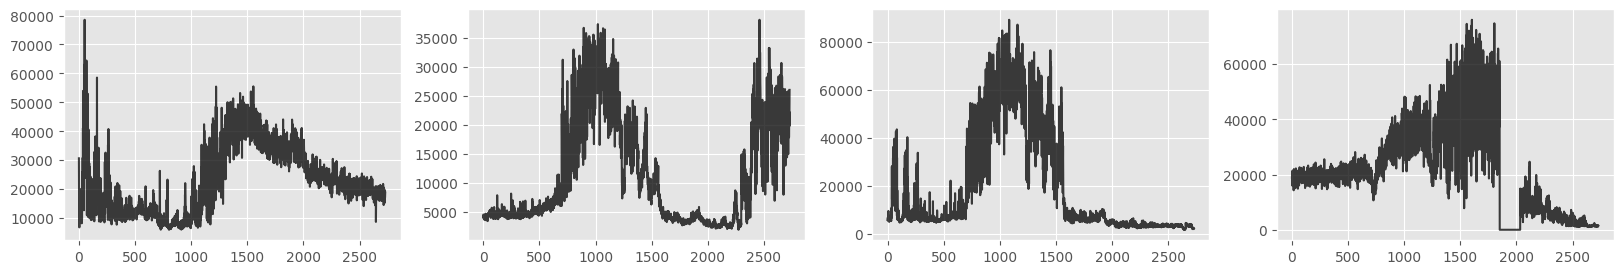

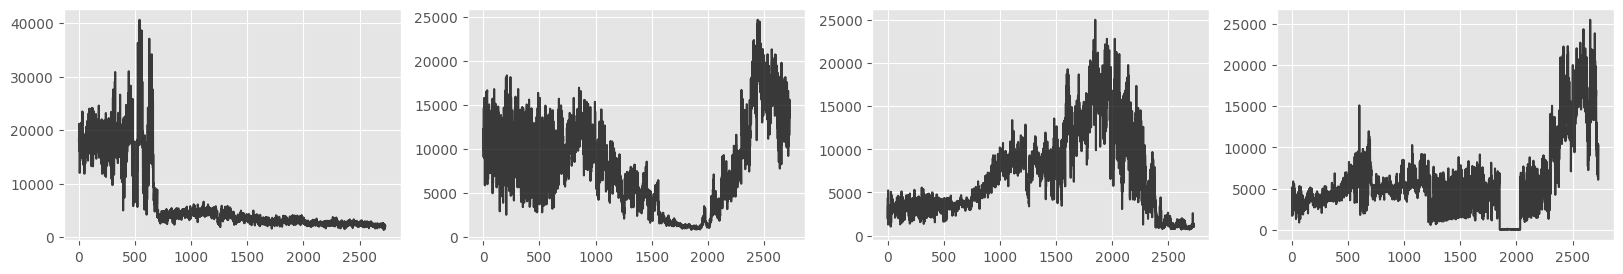

In [83]:
for d in ["x","y","z"]:
    fig = plt.figure(figsize=(20,3))
    for cable in [0,1,2,3]:
        ax = fig.add_subplot(1,4,cable+1)
        ax.plot(band_per_cable[cable][d], color="k", alpha=0.75)

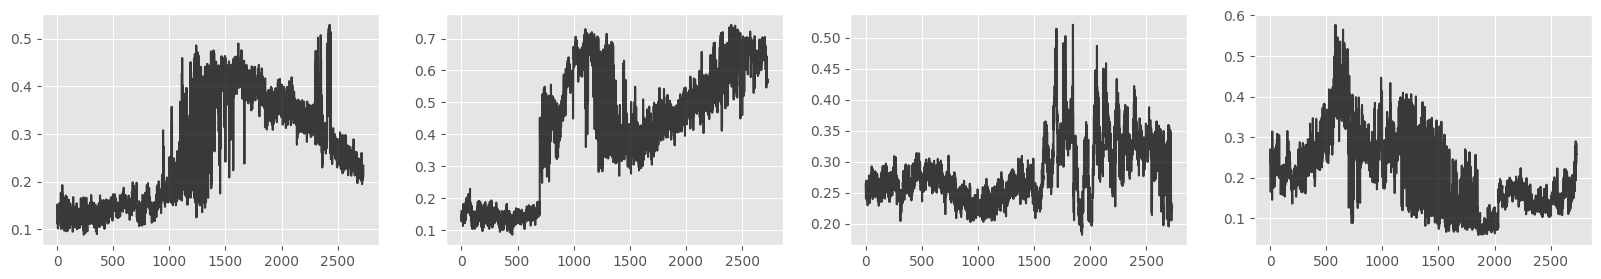

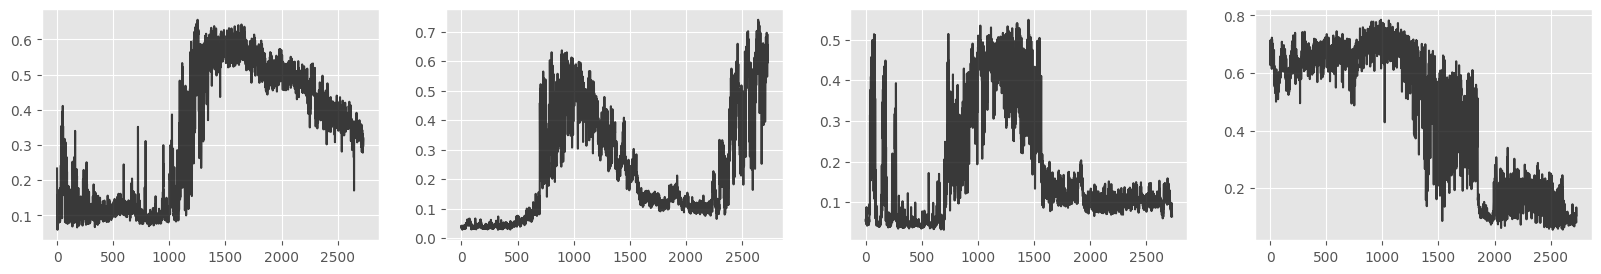

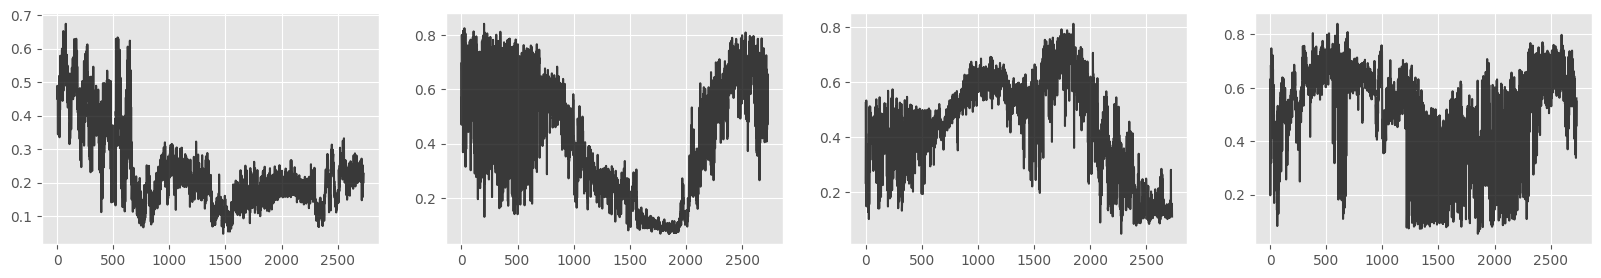

In [84]:
for d in ["x","y","z"]:
    fig = plt.figure(figsize=(20,3))
    for cable in [0,1,2,3]:
        ax = fig.add_subplot(1,4,cable+1)
        ax.plot(norm_band_per_cable[cable][d], color="k", alpha=0.75)